In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [4]:
# read the data, make a df of 150 instances
df1 = pd.read_excel('results/TABU/output_1000e_200.xlsx')
df2 = pd.read_excel('results/TABU/output_1000e_200_ctd1.xlsx')

df = pd.concat([df1, df2])
df = df[df['instance'] < 151]
df = df.rename(columns={'number of movements': 'movements reached'})

df_instances = pd.read_excel('results/instanceData_200.xlsx')
df = pd.merge(df, df_instances, on='instance')


print(df.columns)

Index(['instance', 'movements reached', 'median delay', 'average delay',
       'obj_val', 'tabu_list_size', 'number_of_tweaks', 'affected_movements',
       'epochs', 'time_interval', 'vessel_time_window', 'solution_found',
       'number_of_movements', 'number_of_headways', 'number_of_vessels',
       'average_headway', 'std_dev_headway', 'spread',
       'average_time_between_movements', 'average_travel_time'],
      dtype='object')


In [5]:
# recalculate the objective function
movements_factor = 0.001
headway_factor = 0.001
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor + df['number_of_headways'] * headway_factor
print(df['objective_function'], df['average delay'])

0       1.528636
1       1.737708
2       0.982500
3       0.981103
4       1.861970
          ...   
4495    1.572212
4496    1.776758
4497    1.276758
4498    1.143923
4499    1.401758
Name: objective_function, Length: 4500, dtype: float64 0       1.113636
1       1.317708
2       0.562500
3       0.564103
4       1.446970
          ...   
4495    0.996212
4496    1.200758
4497    0.700758
4498    0.576923
4499    0.825758
Name: average delay, Length: 4500, dtype: float64


In [6]:
feature_cols = ['tabu_list_size','number_of_tweaks', 'affected_movements',
    'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
    'average_time_between_movements', 'average_travel_time']

X = df[feature_cols].values
y = df['objective_function'].values

In [9]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
model = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
import tqdm

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 40  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            if epoch % 10 == 0:
                history.append(float(loss))
                print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = model.state_dict().copy()
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: 0, Loss: 2.6309
Epoch: 0, Loss: 2.5992
Epoch: 0, Loss: 2.3200
Epoch: 0, Loss: 2.6821
Epoch: 0, Loss: 2.7455
Epoch: 0, Loss: 2.4998
Epoch: 0, Loss: 2.5897
Epoch: 0, Loss: 2.7020
Epoch: 0, Loss: 2.4659
Epoch: 0, Loss: 2.0535
Epoch: 0, Loss: 2.5573
Epoch: 0, Loss: 2.2732
Epoch: 0, Loss: 2.5198
Epoch: 0, Loss: 2.5678
Epoch: 0, Loss: 2.5111
Epoch: 0, Loss: 2.4458
Epoch: 0, Loss: 2.3880
Epoch: 0, Loss: 2.5988
Epoch: 0, Loss: 2.4044
Epoch: 0, Loss: 2.2113
Epoch: 0, Loss: 2.6786
Epoch: 0, Loss: 2.1893
Epoch: 0, Loss: 2.4215
Epoch: 0, Loss: 2.3906
Epoch: 0, Loss: 2.3523
Epoch: 0, Loss: 2.7740
Epoch: 0, Loss: 2.2797
Epoch: 0, Loss: 2.4483
Epoch: 0, Loss: 2.5216
Epoch: 0, Loss: 2.1857
Epoch: 0, Loss: 2.3508
Epoch: 0, Loss: 2.0407
Epoch: 0, Loss: 2.5311
Epoch: 0, Loss: 2.2555
Epoch: 0, Loss: 2.9890
Epoch: 0, Loss: 2.0947
Epoch: 0, Loss: 2.5330
Epoch: 0, Loss: 2.4091
Epoch: 0, Loss: 2.0138
Epoch: 0, Loss: 2.1823
Epoch: 0, Loss: 2.0680
Epoch: 0, Loss: 2.1948
Epoch: 0, Loss: 2.0856
Epoch: 0, L

<All keys matched successfully>

MSE: 0.16
RMSE: 0.40


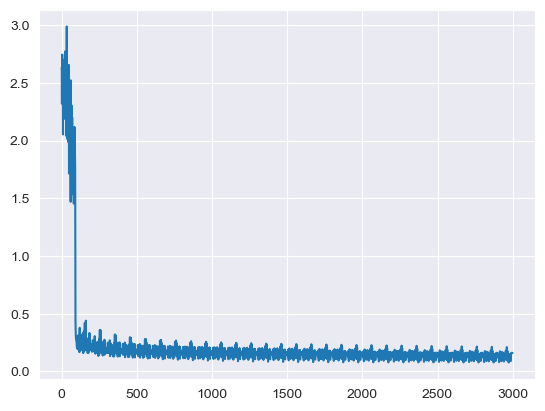

In [11]:
# plot the loss
import matplotlib.pyplot as plt

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

C:\Users\ilias\AppData\Local\Temp\ipykernel_20848\3711771179.py:8: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y_pred[0], y_test[0], 1)


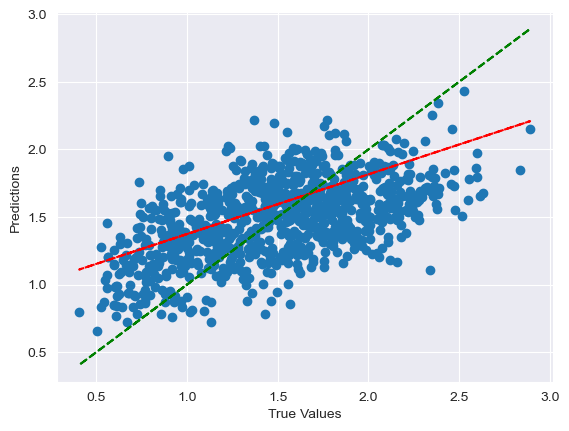

In [13]:
# plot the predictions as a scatter plot
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
# plot the line of best fit
z = np.polyfit(y_pred[0], y_test[0], 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()

In [14]:
# save the model
torch.save(model.state_dict(), 'results/TABU/models/NN_model_150.pth')

# save the scaler
import pickle
with open('results/TABU/models/scaler_150.pkl', 'wb') as f:
    pickle.dump(scaler, f)